# Machine Learning Prediction

This notebook includes:
- Call the jupyter notebook "notebook/feature_engineering.ipynb" to carry out the feature enginnering with flexible parameterization.
- Comparision of five ML models: TabPFN regression, Random Forest regression, XGBoost regression, LightGBM regression, CatBoost regression.
- Select the best-performing model and use it to predict day ahead electricity price changes.

# 1. Configuration and Parameterization

In [1]:
#configuration
# path 
OUTPUT_DIR = "data/"

RANDOM_STATE=47 # random seed
TEST_SIZE=0.1 # portion of the test set
n_splits=5 # step for cross validation

# parameter space
param_grid_call = {
    'input_dir': ["data/"], # input dir as parameter, which allows this notebook to access and call other notebooks flexibly.
    'missing_outlier_r_threshold': [6], # threshold for the removal of rows with lage number of missing and outliers, recommend 6 or 7
    'missing_outlier_c_threshold': [200], # threshold for the removal of columns with lage number of missing and outliers, recommend 200
    'impute_method': ['interp'], # imputation methods: 'zero', 'mean', 'median', 'mice', 'knn', 'interp'
    'corr_method': ['spearman'], # 'pearson' or 'spearman'
    'corr_threshold': [0.9], # correlation threshold to determine close related feature pairs, recommend 0.8, 0.85 or 0.9
    'target_corr_threshold': [0.01], # correlation threshold to determine close related feature pairs, recommend 0.01 or 0.02
    'null_importance_threshold': [90], # threshold for null importance, recommend 80 or 90
    'OnlyOrigNumFeatures': [True], # whether only provide the original numerical features for the learning
    'KeepOrigNumFeatures': [True], # whether keep original numerical features for the learning
    'UseTimeSeries': [False], # use the complete time series of trian and test data set
    'RemoveMissingOutlier': [False] # whether remove the rows and columns with a large number of missing and outlier values
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_xgb = {
    'max_depth': [3, 6, 9],  
    'reg_alpha': [0.1, 0.2, 0.3], 
    'n_estimators': [50],
    'learning_rate': [0.05, 0.1, 0.2],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0]
}

param_grid_lgb = {
    'boosting_type': ['gbdt'],
    'num_leaves': [14, 15, 30, 50],
    'learning_rate': [0.045, 0.05, 0.1, 0.2],
    'feature_fraction': [0.6, 0.8, 0.9],
    'bagging_fraction': [0.6, 0.8, 0.9],
    'bagging_freq': [3, 5, 7]
}

In [2]:
# import of libraries
import numpy as np
import pandas as pd
import warnings
import papermill as pm
import scrapbook as sb
import torch
import shutil

from pathlib import Path
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from tabpfn import TabPFNRegressor
from sklearn.metrics import root_mean_squared_error
from scipy.stats import spearmanr
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

warnings.filterwarnings('ignore')
if not torch.cuda.is_available():
    raise SystemError('GPU device not found. For fast training, please enable GPU. See section above for instructions.')

# 2. Call the notebook for feature engineering and choose the best engineered dataset

In [3]:
# clear the experiment folder 
folder = Path("experiment")
shutil.rmtree(folder, ignore_errors=True)
folder.mkdir(parents=True, exist_ok=True)

In [4]:
# call the jupyter notebook "notebook/feature_engineering.ipynb" with parameterization
best_score = (-1, 0)
best_params = {}
_X_train = pd.DataFrame()
_y_train = pd.DataFrame()                
_X_test = pd.DataFrame() 

for params in ParameterGrid(param_grid_call):
    try:
        output = pm.execute_notebook(
            input_path="notebook/feature_engineering.ipynb",
            output_path=f'experiment/experiment_{hash(str(params))}.ipynb',
            parameters=params
        )

        nb = sb.read_notebook(f'experiment/experiment_{hash(str(params))}.ipynb')
        spearman = nb.scraps["spearman"].data
        r2 = nb.scraps["r2"].data
        score = (spearman, r2)
        _X_train = nb.scraps["X_train"].data
        _y_train = nb.scraps["y_train"].data                 
        _X_test = nb.scraps["X_test"].data 
    except:
        score = (-1, 0)
        print(f'experiment_{hash(str(params))}.ipynb stopped')
        display(params)
        display(best_score)
        display(best_params)
    
    if score > best_score:
        best_score = score
        best_params = params
        best_X_train = _X_train
        best_y_train = _y_train
        best_X_test = _X_test

print("The optimal select feature engineering parameter:")
display(best_params)
print(f"The best prediction score (spearman corr, r2):\n {best_score}")

Executing:   0%|          | 0/108 [00:00<?, ?cell/s]

The optimal select feature engineering parameter:


{'KeepOrigNumFeatures': True,
 'OnlyOrigNumFeatures': True,
 'RemoveMissingOutlier': False,
 'UseTimeSeries': False,
 'corr_method': 'spearman',
 'corr_threshold': 0.9,
 'impute_method': 'interp',
 'input_dir': 'data/',
 'missing_outlier_c_threshold': 200,
 'missing_outlier_r_threshold': 6,
 'null_importance_threshold': 90,
 'target_corr_threshold': 0.01}

The best prediction score (spearman corr, r2):
 (0.3475189633375475, 0.055811608931725876)


# 3. Comparision of ML models

In [5]:
# get laerning data
X_train = best_X_train.drop('ID', axis=1).copy()
X_test = best_X_test.drop('ID', axis=1).copy()
y_train = best_y_train['TARGET'].copy()
submission = best_X_test[['ID']].copy()

In [6]:
# compare ML regression models
models = [
    ('TabPFN', TabPFNRegressor(random_state=42, device="cuda")),
    ('RandomForest', RandomForestRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42)),
    ('LightGBM', LGBMRegressor(random_state=42, verbose=0)),
    ('CatBoost', CatBoostRegressor(random_state=42, verbose=0))
]

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
corr_spearman = {}
score_mse = {}

for name, model in models:
    print(name)
    model.fit(X_train_.to_numpy(), y_train_.to_numpy())
    y_pred_ = model.predict(X_test_)
    corr = spearmanr(y_test_, y_pred_).correlation
    corr_spearman[name] = corr * 100
    print(f"spearman = {corr_spearman[name]:.4f}%")
    rmse = root_mean_squared_error(y_test_, y_pred_)
    score_mse[name] = rmse
    print(f"rmse = { rmse:.4f}")

TabPFN
spearman = 21.3420%
rmse = 1.0615
RandomForest
spearman = 20.3012%
rmse = 1.1681
XGBoost
spearman = 13.1870%
rmse = 1.3096
LightGBM
spearman = 19.6602%
rmse = 1.2092
CatBoost
spearman = 17.5131%
rmse = 1.2200


Text(0.5, 1.0, 'Model Comparison')

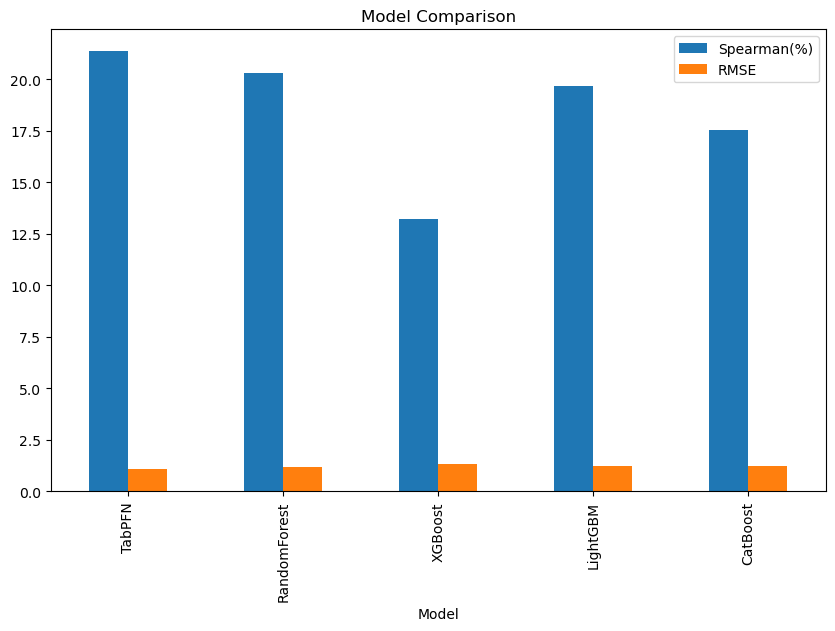

In [7]:
# plot model comparision results
df = pd.DataFrame(list(corr_spearman.items()), columns=['Model', 'Spearman(%)'])
df = df.merge(pd.DataFrame(list(score_mse.items()), columns=['Model', 'RMSE']), on='Model', how='left')
ax = df.plot(x='Model', y=['Spearman(%)','RMSE'], kind='bar', figsize=(10, 6))
ax.set_title('Model Comparison')

In [8]:
# get the best 3 prediction models
df_compare = df.copy()
df_compare.sort_values(by=['Spearman(%)', 'RMSE'], ascending=[False, True], ignore_index=True, inplace=True)
best_models = df_compare['Model'].values[:3]
display(best_models)

array(['TabPFN', 'RandomForest', 'LightGBM'], dtype=object)

In [9]:
df_compare['Model'].values[:3]

array(['TabPFN', 'RandomForest', 'LightGBM'], dtype=object)

# 4. Prediction using the best performed ML model

In [10]:
# define the TabPFN regression model with cross validation
def TabPFNRegressorCV(X, y, Xt):
    test_predictions = []
    oof_predictions = np.zeros(len(X))

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    
    print(f"Starting {n_splits}-fold cross-validation...")
    
    for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
        print(f"\n--- Fold {fold+1}/{n_splits} ---")
        
        Xtrain, Xval = X.iloc[train_index], X.iloc[val_index]
        ytrain, yval = y.iloc[train_index], y.iloc[val_index]
    
        model = TabPFNRegressor(random_state=RANDOM_STATE, device="cuda")
        model.fit(Xtrain, ytrain)
        
        val_preds = model.predict(Xval)
        oof_predictions[val_index] = val_preds
        r2 = root_mean_squared_error(yval, val_preds)
        print(f"rmse score on validation set for Fold {fold+1}: {r2:.5f}")
        
        test_preds = model.predict(Xt)
        test_predictions.append(test_preds)
    
    return np.mean(test_predictions, axis=0)

In [11]:
# define the Random Forest regression model with cross validation
def RandomForestRegressorCV(X, Y):
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    reg = RandomForestRegressor(random_state=RANDOM_STATE)
    grid_search = GridSearchCV(estimator=reg, param_grid=param_grid_rf, cv=n_splits, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)
    grid_search.fit(X_train_, y_train_)
    print("Best parameters: ", grid_search.best_params_)

    y_pred = grid_search.predict(X_test_)

    rmse = root_mean_squared_error(y_test_, y_pred)
    print('rmse on test set: {:.2f}'.format(rmse))

    return {"parameters": grid_search.best_params_, "model": grid_search}

In [12]:
# define the XGBoost regression model with cross validation
def XGBoostRegressorCV(X, Y):
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    reg = XGBRegressor(booster='gbtree', objective='reg:squarederror')
    grid_search = GridSearchCV(estimator=reg, param_grid=param_grid_xgb, cv=n_splits, scoring='neg_mean_squared_error', return_train_score=True, verbose=1, n_jobs=-1)
    grid_search.fit(X_train_, y_train_)

    best_parameters = grid_search.best_params_
    best_rmse = -grid_search.best_score_
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test_)
    rmse = root_mean_squared_error(y_test_, y_pred)

    print("Best parameters: ", grid_search.best_params_)
    print("Best score: ", best_rmse)
    print("MSE on test data: ", rmse)

    return {"parameters": best_parameters, "model":best_model}

In [13]:
# define the lightGBM regression model with cross validation
def LightGBMRegressorCV(X, Y):
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
    model = LGBMRegressor(objective='regression', metric='mse')
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid_lgb, cv=n_splits, scoring='neg_root_mean_squared_error', verbose=0, n_jobs=-1)
    grid_search.fit(X_train_, y_train_)
    
    best_parameters = grid_search.best_params_
    best_rmse = -grid_search.best_score_
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test_)
    rmse = root_mean_squared_error(y_test_, y_pred)

    print("Best parameters: ", best_parameters)
    print("Best score: ", best_rmse)
    print("rmse on test data: ", rmse)

    return {"parameters": best_parameters, "model":best_model}

In [14]:
def CatBoostRegressorCV(X, y, Xt):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    oof = np.zeros(len(X))
    test_predictions = []

    for fold, (tr, va) in enumerate(kf.split(X), 1):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]

        train_pool = Pool(X_tr, y_tr)
        valid_pool = Pool(X_va, y_va)

        model = CatBoostRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_seed=RANDOM_STATE, silent=True)
        model.fit(train_pool, eval_set=valid_pool, verbose=False)

        pred_va = model.predict(valid_pool)
        oof[va] = pred_va
        
        test_preds = model.predict(Xt)
        test_predictions.append(test_preds)

    score = root_mean_squared_error(y, oof)
    print(f'rmse on data set: {score:.2f}')
    
    return np.mean(test_predictions, axis=0)

In [15]:
# forecast day ahead price changes with the best 3 performed ML models
for model_name in best_models:
    if model_name == 'TabPFN':
        print('Prediction using the TabPFN regression:')
        submission['TARGET'] = TabPFNRegressorCV(X_train, y_train, X_test)
        submission.to_csv(f"{OUTPUT_DIR}tabpfn_submission.csv", index=False)
    elif model_name == 'RandomForest':
        print('Prediction using the Random Forest regression:')
        ml_model = RandomForestRegressorCV(X_train, y_train)
        submission['TARGET'] = ml_model['model'].predict(X_test)
        submission.to_csv(f"{OUTPUT_DIR}randomforest_submission.csv", index=False)
    elif model_name == 'XGBoost':
        print('Prediction using the XGBoost regression:')
        ml_model = XGBoostRegressorCV(X_train, y_train)
        submission['TARGET'] = ml_model['model'].predict(X_test)
        submission.to_csv(f"{OUTPUT_DIR}xgboost_submission.csv", index=False)
    elif model_name == 'CatBoost':
        print('Prediction using the CatBoost regression:')
        submission['TARGET'] = CatBoostRegressorCV(X_train, y_train, X_test)
        submission.to_csv(f"{OUTPUT_DIR}catboost_submission.csv", index=False)
    else:
        print('Prediction using the LightGBM regression:')
        ml_model = LightGBMRegressorCV(X_train, y_train)
        submission['TARGET'] = ml_model['model'].predict(X_test)
        submission.to_csv(f"{OUTPUT_DIR}lightgbm_submission.csv", index=False)

Prediction using the TabPFN regression:
Starting 5-fold cross-validation...

--- Fold 1/5 ---
rmse score on validation set for Fold 1: 1.08413

--- Fold 2/5 ---
rmse score on validation set for Fold 2: 1.10456

--- Fold 3/5 ---
rmse score on validation set for Fold 3: 1.04530

--- Fold 4/5 ---
rmse score on validation set for Fold 4: 0.84800

--- Fold 5/5 ---
rmse score on validation set for Fold 5: 0.98694
Prediction using the Random Forest regression:
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters:  {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
rmse on test set: 1.02
Prediction using the LightGBM regression:
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be i